# Speed, memory and scalability testing


In [16]:
from gptide.gpscipy import GPtideScipy
from gpvecchia.vecchia import GPtideVecchia
from dgpsi import gp, kernel

from gpvecchia.vecchia_utils import find_nn
from numba import njit

import numpy as np
import matplotlib.pyplot as plt

import time
from memory_profiler import memory_usage

import seaborn as sns
sns.set_style("white")

We use an exponential-quadratic  kernel with a length scale $\ell$ = 100 and variance $\eta$ = $1.5^2$. The noise ($\sigma$) is 0.5. The total length of the domain is 2500 and we sample 100 data points.

`GPvecchia` only accepts covariance functions that use a distance matrix. 

In [2]:
@njit(cache=True)
def expquad_1d(x, xpr, params):
    eta, l = params
    d = np.sum((x-xpr)**2)
    return eta**2. * np.exp(-d/(2*l*l))

In [20]:
####
# These are our kernel input parameters
noise = 0.5
η = 2
ℓ = 100
covfunc = expquad_1d

###
# Domain size parameters
dx = 1.
N = 600000
covparams = (η, ℓ)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]

# A re-ordering function should always be specified - the default is no re-ordering
order_func = np.random.permutation
order_params = len(xd)
ordering_index = order_func(order_params) # we don't need to do this, unless we compute neighbours outside the object

## Initialise the GPtide object and sample from the prior

Always specify a re-ordering function. Other optional args can be left as default.


In [21]:
GP = GPtideVecchia(xd, xd, noise, covfunc, covparams, order_func=order_func, order_params=order_params)

# Note the default is to not add noise
yd_noisy = GP.sample_prior(samples=1, add_noise=True)

# plt.figure()
# plt.plot(xd, yd_noisy, '.')
# plt.ylabel('some data')
# plt.xlabel('x')
# plt.xlim(0, 5000)

## Search for nearest neighbours 

So we can compare fixed neighbours (no search) vs. when a search is required. 

In [22]:
num_neigh = 30
xd_reord = xd[ordering_index] # re-ordering essential for Vecchia
yd_reord = yd_noisy[ordering_index]

nn_array = find_nn(xd_reord, num_neigh)
print(nn_array.shape)

ix = 80000
# plt.plot(xd_reord, yd_reord, '.')
# plt.plot(xd_reord[nn_array[ix]], yd_reord[nn_array[ix]], 'ro')
# plt.plot(xd_reord[ix], yd_reord[ix], 'go')
# plt.xlim(xd_reord[ix]-100*dx, xd_reord[ix]+100*dx)

(600000, 31)


## Setup some speed tests

In [23]:
# def benchmark_scaling(func, input_generator, sizes):
#     times = []
#     for size in sizes:
#         x = input_generator(size)
#         start = time.perf_counter()
#         func(x)
#         end = time.perf_counter()
#         times.append(end - start)
#         print(f"Size {size}: {times[-1]:.6f}s")
#     return times

def benchmark_GPtideScipy(sizes, x, y, noise, covfunc, covparams):
    times = []
    for size in sizes:
        GP_scipy = GPtideScipy(x[:size], x[:size], noise, covfunc, covparams)
        GP_scipy.log_marg_likelihood(y[:size][:,None])
        
        start = time.perf_counter()
        GP_scipy = GPtideScipy(x[:size], x[:size], noise, covfunc, covparams)
        GP_scipy.log_marg_likelihood(y[:size][:,None])
        end = time.perf_counter()
        times.append(end - start)
        print(f"GPScipy: size {size}: {times[-1]:.6f}s")
    return times
        
    
def benchmark_GPVecchia_nosearch(sizes, x, y, noise, covfunc, covparams):
    times = []
    for size in sizes:
        nn_array = find_nn(x[:size], 30)
        ordering_index = np.random.permutation(size)
        
        GP_vecchia = GPtideVecchia(x[:size], x[:size], noise, covfunc, covparams, nn_array=nn_array, order_idx=ordering_index)
        GP_vecchia.log_marg_likelihood(y[:size][:,None])
        
        start = time.perf_counter()
        GP_vecchia = GPtideVecchia(x[:size], x[:size], noise, covfunc, covparams, nn_array=nn_array, order_idx=ordering_index)
        GP_vecchia.log_marg_likelihood(y[:size][:,None])
        end = time.perf_counter()
        times.append(end - start)
        print(f"GPVecchia no search: size {size}: {times[-1]:.6f}s")
    return times


def benchmark_GPVecchia_search(sizes, x, y, noise, covfunc, covparams):
    times = []
    for size in sizes:
        GP_vecchia = GPtideVecchia(x[:size], x[:size], noise, covfunc, covparams)
        GP_vecchia.log_marg_likelihood(y[:size][:,None])

        start = time.perf_counter()
        GP_vecchia = GPtideVecchia(x[:size], x[:size], noise, covfunc, covparams)
        GP_vecchia.log_marg_likelihood(y[:size][:,None])
        end = time.perf_counter()
        times.append(end - start)
        print(f"GPVecchia w search: size {size}: {times[-1]:.6f}s")
    return times    
    
def benchmark_DGP(sizes, X, Y, covparams):
    times = []
    for size in sizes:
        m_gp = gp(X[:size], Y[:size][:,None], kernel(length=np.array([100.]),name='sexp', nugget_est=True, scale_est=True), vecchia=True)
        m_gp.kernel.llik_vecch(covparams)
        
        start = time.perf_counter()
        # m_gp = gp(X[:size], Y[:size][:,None], kernel(length=np.array([100.]),name='sexp', nugget_est=True, scale_est=True), vecchia=True)
        m_gp.kernel.llik_vecch(covparams)
        end = time.perf_counter()
        times.append(end - start)
        print(f"DGP: Size {size}: {times[-1]:.6f}s")
    return times

In [24]:
sizes = [10, 100, 500, 1000, 5000, 8000, 100000, 200000, 400000, 600000]


In [59]:
gptide_times = benchmark_GPtideScipy(sizes[:-4], xd_reord, yd_reord, noise, covfunc, covparams)

GPScipy: size 10: 0.000220s
GPScipy: size 100: 0.000340s
GPScipy: size 500: 0.003294s
GPScipy: size 1000: 0.079985s
GPScipy: size 5000: 2.204391s
GPScipy: size 8000: 5.388658s


In [60]:
gpvechnn_times = benchmark_GPVecchia_nosearch(sizes, xd_reord, yd_reord, noise, covfunc, covparams)

GPVecchia no search: size 10: 0.001591s
GPVecchia no search: size 100: 0.002217s
GPVecchia no search: size 500: 0.005430s
GPVecchia no search: size 1000: 0.010287s
GPVecchia no search: size 5000: 0.046568s
GPVecchia no search: size 8000: 0.069406s
GPVecchia no search: size 100000: 0.789935s
GPVecchia no search: size 200000: 1.593904s
GPVecchia no search: size 400000: 3.166245s
GPVecchia no search: size 600000: 4.328807s


In [61]:
gpvechoo_times = benchmark_GPVecchia_search(sizes, xd_reord, yd_reord, noise, covfunc, covparams)

GPVecchia w search: size 10: 0.001895s
GPVecchia w search: size 100: 0.015925s
GPVecchia w search: size 500: 0.033387s
GPVecchia w search: size 1000: 0.042057s
GPVecchia w search: size 5000: 0.119317s
GPVecchia w search: size 8000: 0.176893s
GPVecchia w search: size 100000: 2.125847s
GPVecchia w search: size 200000: 4.120051s
GPVecchia w search: size 400000: 8.405169s
GPVecchia w search: size 600000: 13.457320s


In [62]:
dgp_times = benchmark_DGP(sizes, xd_reord, yd_reord, covparams)

DGP: Size 10: 0.005885s
DGP: Size 100: 0.007323s
DGP: Size 500: 0.009894s
DGP: Size 1000: 0.016315s
DGP: Size 5000: 0.053344s
DGP: Size 8000: 0.078133s
DGP: Size 100000: 0.264395s
DGP: Size 200000: 0.478634s
DGP: Size 400000: 1.074363s
DGP: Size 600000: 1.538602s


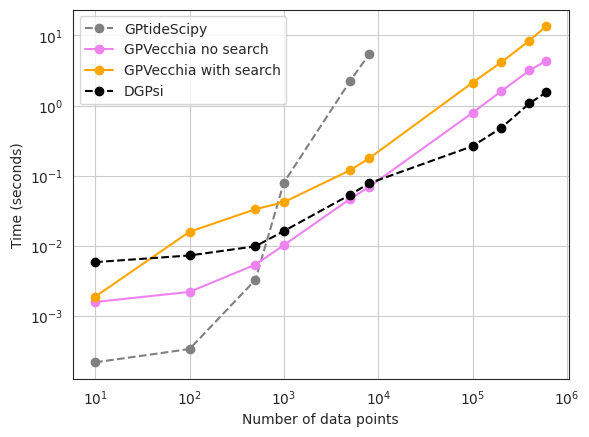

In [64]:
fig, ax = plt.subplots()
ax.plot(sizes[:-4], gptide_times, label='GPtideScipy', marker='o', c='grey', linestyle='--')
ax.plot(sizes, gpvechnn_times, label='GPVecchia no search', marker='o', c='violet')
ax.plot(sizes, gpvechoo_times, label='GPVecchia with search', marker='o', c='orange')
ax.plot(sizes, dgp_times, label='DGPsi', marker='o', c='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of data points')
ax.set_ylabel('Time (seconds)')
ax.legend()
ax.grid()

In [40]:
def run_GPtideScipy(size, x, y, noise, covfunc, covparams):
    GP_scipy = GPtideScipy(x[:size], x[:size], noise, covfunc, covparams)
    return GP_scipy.log_marg_likelihood(y[:size][:,None])

def benchmark_GPtideScipy_search_memory(sizes, x, y, noise, covfunc, covparams):
    times = []
    memories = []

    for size in sizes:
        print(f"\nRunning size {size}...")

        start = time.perf_counter()
        mem_usage = memory_usage(
            (run_GPtideScipy, (size, x, y, noise, covfunc, covparams)),
            max_usage=True,  # only record the peak
            interval=0.1,     # sampling interval in seconds
            retval=False      # don't need the return value here
        )
        end = time.perf_counter()

        runtime = end - start
        peak_mem = mem_usage  # in MiB

        times.append(runtime)
        memories.append(peak_mem)

        print(f"Size {size}: time = {runtime:.6f}s, peak memory = {peak_mem:.2f} MiB")

    return times, memories

def run_gpvecchia_search(size, x, y, noise, covfunc, covparams):
    GP_vecchia = GPtideVecchia(x[:size], x[:size], noise, covfunc, covparams)
    return GP_vecchia.log_marg_likelihood(y[:size][:, None])

def benchmark_gpvecchia_search_memory(sizes, x, y, noise, covfunc, covparams):
    times = []
    memories = []

    for size in sizes:
        print(f"\nRunning size {size}...")

        start = time.perf_counter()
        mem_usage = memory_usage(
            (run_gpvecchia_search, (size, x, y, noise, covfunc, covparams)),
            max_usage=True,  # only record the peak
            interval=0.1,     # sampling interval in seconds
            retval=False      # don't need the return value here
        )
        end = time.perf_counter()

        runtime = end - start
        peak_mem = mem_usage  # in MiB

        times.append(runtime)
        memories.append(peak_mem)

        print(f"Size {size}: time = {runtime:.6f}s, peak memory = {peak_mem:.2f} MiB")

    return times, memories


def run_gpvecchia_nn(size, x, y, noise, covfunc, covparams, nn_array, order_idx):
    GP_vecchia = GPtideVecchia(x[:size], x[:size], noise, covfunc, covparams, nn_array=nn_array, order_idx=order_idx)
    return GP_vecchia.log_marg_likelihood(y[:size][:, None])

def benchmark_gpvecchia_NOsearch_memory(sizes, x, y, noise, covfunc, covparams):
    times = []
    memories = []

    for size in sizes:
        print(f"\nRunning size {size}...")
        nn_array = find_nn(x[:size], 30)
        ordering_index = np.random.permutation(size)

        start = time.perf_counter()
        mem_usage = memory_usage(
            (run_gpvecchia_nn, (size, x, y, noise, covfunc, covparams, nn_array, ordering_index)),
            max_usage=True,  # only record the peak
            interval=0.1,     # sampling interval in seconds
            retval=False      # don't need the return value here
        )
        end = time.perf_counter()

        runtime = end - start
        peak_mem = mem_usage  # in MiB

        times.append(runtime)
        memories.append(peak_mem)

        print(f"Size {size}: time = {runtime:.6f}s, peak memory = {peak_mem:.2f} MiB")

    return times, memories


def run_DGP_nn(m_gp, covparams):
    return m_gp.kernel.llik_vecch(covparams)

def benchmark_DGP_memory(sizes, x, y, covparams):
    times = []
    memories = []

    for size in sizes:
        print(f"\nRunning size {size}...")
        m_gp = gp(x[:size], y[:size][:,None], kernel(length=np.array([100.]),name='sexp', nugget_est=True, scale_est=True), vecchia=True)

        start = time.perf_counter()
        mem_usage = memory_usage(
            (run_DGP_nn, (m_gp, covparams)),
            max_usage=True,  # only record the peak
            interval=0.1,     # sampling interval in seconds
            retval=False      # don't need the return value here
        )
        end = time.perf_counter()

        runtime = end - start
        peak_mem = mem_usage  # in MiB

        times.append(runtime)
        memories.append(peak_mem)

        print(f"Size {size}: time = {runtime:.6f}s, peak memory = {peak_mem:.2f} MiB")

    return times, memories

In [37]:
gpscipy_times, gpscipy_mem = benchmark_GPtideScipy_search_memory(sizes[:-4], xd_reord, yd_reord, noise, covfunc, covparams)


Running size 10...
Size 10: time = 0.348024s, peak memory = 2679.69 MiB

Running size 100...
Size 100: time = 0.329877s, peak memory = 2679.69 MiB

Running size 500...
Size 500: time = 0.305968s, peak memory = 2681.44 MiB

Running size 1000...
Size 1000: time = 0.298243s, peak memory = 2681.17 MiB

Running size 5000...
Size 5000: time = 1.911036s, peak memory = 3063.29 MiB

Running size 8000...
Size 8000: time = 4.158897s, peak memory = 3661.54 MiB


In [53]:
gpvechnn_times, gpvechnn_mem = benchmark_gpvecchia_NOsearch_memory(sizes, xd_reord, yd_reord, noise, covfunc, covparams)


Running size 10...
Size 10: time = 0.525458s, peak memory = 1950.29 MiB

Running size 100...
Size 100: time = 0.274254s, peak memory = 1950.29 MiB

Running size 500...
Size 500: time = 0.300042s, peak memory = 1950.41 MiB

Running size 1000...
Size 1000: time = 0.293797s, peak memory = 1950.41 MiB

Running size 5000...
Size 5000: time = 0.309225s, peak memory = 1950.54 MiB

Running size 8000...
Size 8000: time = 0.356605s, peak memory = 1950.53 MiB

Running size 100000...
Size 100000: time = 0.930960s, peak memory = 1981.25 MiB

Running size 200000...
Size 200000: time = 2.216229s, peak memory = 2031.31 MiB

Running size 400000...
Size 400000: time = 4.016611s, peak memory = 2038.71 MiB

Running size 600000...
Size 600000: time = 5.155303s, peak memory = 2096.41 MiB


In [54]:
gpvechoo_times, gpvechoo_mem = benchmark_gpvecchia_search_memory(sizes, xd_reord, yd_reord, noise, covfunc, covparams)


Running size 10...
Size 10: time = 0.312089s, peak memory = 1954.53 MiB

Running size 100...
Size 100: time = 0.315030s, peak memory = 1954.66 MiB

Running size 500...
Size 500: time = 0.302375s, peak memory = 1954.64 MiB

Running size 1000...
Size 1000: time = 0.320774s, peak memory = 1954.51 MiB

Running size 5000...
Size 5000: time = 0.511542s, peak memory = 1954.51 MiB

Running size 8000...
Size 8000: time = 0.330417s, peak memory = 1954.63 MiB

Running size 100000...
Size 100000: time = 2.523946s, peak memory = 2085.60 MiB

Running size 200000...
Size 200000: time = 4.607508s, peak memory = 2244.43 MiB

Running size 400000...
Size 400000: time = 8.823056s, peak memory = 2573.68 MiB

Running size 600000...
Size 600000: time = 13.560667s, peak memory = 2822.35 MiB


In [41]:
gp_dgp_times, gp_dgp_mem = benchmark_DGP_memory(sizes, xd_reord, yd_reord, covparams)


Running size 10...
Size 10: time = 0.198654s, peak memory = 2809.02 MiB

Running size 100...
Size 100: time = 0.249944s, peak memory = 2809.02 MiB

Running size 500...
Size 500: time = 0.260431s, peak memory = 2809.02 MiB

Running size 1000...
Size 1000: time = 0.279708s, peak memory = 2809.02 MiB

Running size 5000...
Size 5000: time = 0.294622s, peak memory = 2816.90 MiB

Running size 8000...
Size 8000: time = 0.291179s, peak memory = 2830.02 MiB

Running size 100000...
Size 100000: time = 0.390213s, peak memory = 2847.29 MiB

Running size 200000...
Size 200000: time = 0.548323s, peak memory = 2841.09 MiB

Running size 400000...
Size 400000: time = 1.160406s, peak memory = 2951.23 MiB

Running size 600000...
Size 600000: time = 2.192839s, peak memory = 2950.43 MiB


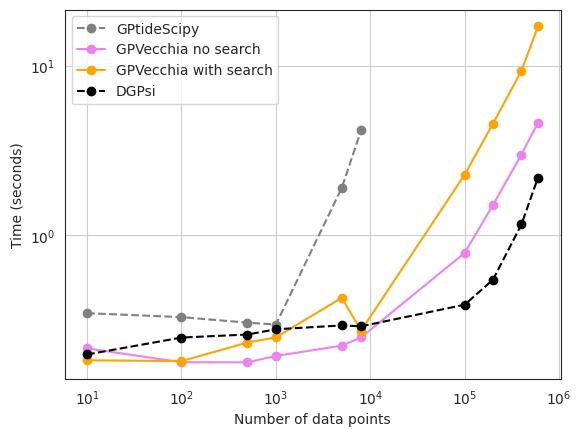

In [51]:
fig, ax = plt.subplots()
ax.plot(sizes[:-4], gpscipy_times, label='GPtideScipy', marker='o', c='grey', linestyle='--')
ax.plot(sizes, gpvechnn_times, label='GPVecchia no search', marker='o', c='violet')
ax.plot(sizes, gpvechoo_times, label='GPVecchia with search', marker='o', c='orange')
ax.plot(sizes, gp_dgp_times, label='DGPsi', marker='o', c='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of data points')
ax.set_ylabel('Time (seconds)')
ax.legend()
ax.grid()

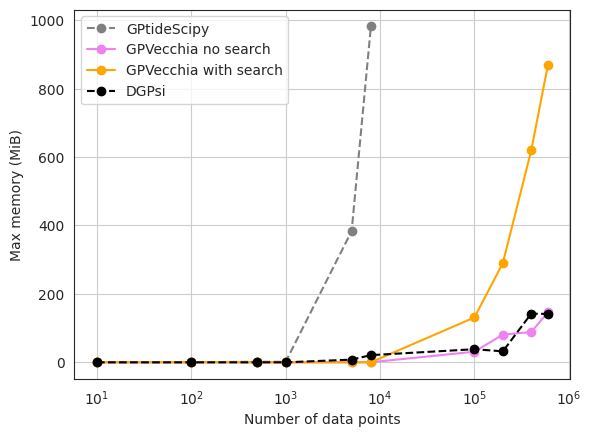

In [58]:
fig, ax = plt.subplots()
ax.plot(sizes[:-4], np.array(gpscipy_mem) - gpscipy_mem[0], label='GPtideScipy', marker='o', c='grey', linestyle='--')
ax.plot(sizes, np.array(gpvechnn_mem) - gpvechnn_mem[0], label='GPVecchia no search', marker='o', c='violet')
ax.plot(sizes, np.array(gpvechoo_mem) - gpvechoo_mem[0], label='GPVecchia with search', marker='o', c='orange')
ax.plot(sizes, np.array(gp_dgp_mem) - gp_dgp_mem[0], label='DGPsi', marker='o', c='k', linestyle='--')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Number of data points')
ax.set_ylabel('Max memory (MiB)')
ax.legend()
ax.grid()